In [1]:
import numpy as np
from keras.optimizers import RMSprop
from keras.models import Sequential
from keras.layers import Dense, Dropout, Activation, Flatten
from keras.layers import Conv2D, MaxPooling2D, Lambda
from keras.layers import Dense
from keras.utils import np_utils
from keras.preprocessing.image import ImageDataGenerator
from sklearn.preprocessing import LabelEncoder
from sklearn.cross_validation import train_test_split
import cv2
import scipy
import os
%matplotlib inline
import matplotlib.pyplot as plt


/usr/local/lib/python2.7/dist-packages/h5py/__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters
Using TensorFlow backend.
/usr/local/lib/python2.7/dist-packages/sklearn/cross_validation.py:41: DeprecationWarning: This module was deprecated in version 0.18 in favor of the model_selection module into which all the refactored classes and functions are moved. Also note that the interface of the new CV iterators are different from that of this module. This module will be removed in 0.20.
  "This module will be removed in 0.20.", DeprecationWarning)


In [2]:
epochs = 20
BASE_DIR = '../'
batch_size = 32

In [3]:
def get_model():
    model = Sequential()
    model.add(Lambda(lambda x: x * 1./255., input_shape=(120, 160, 3), output_shape=(120, 160, 3)))
    model.add(Conv2D(32, (3, 3), input_shape=(120, 160, 3)))
    model.add(Activation('relu'))
    model.add(MaxPooling2D(pool_size=(2, 2)))

    model.add(Conv2D(32, (3, 3)))
    model.add(Activation('relu'))
    model.add(MaxPooling2D(pool_size=(2, 2)))

    model.add(Conv2D(64, (3, 3)))
    model.add(Activation('relu'))
    model.add(MaxPooling2D(pool_size=(2, 2)))

    model.add(Flatten())  # this converts our 3D feature maps to 1D feature vectors
    model.add(Dense(64))
    model.add(Activation('relu'))
    model.add(Dropout(0.7))
    model.add(Dense(1))
    model.add(Activation('sigmoid'))
    rms = RMSprop(lr = 0.001,)
    model.compile(loss='binary_crossentropy',
                optimizer=rms,
                metrics=['accuracy'])

    return model

In [4]:
model = get_model()
print(model.summary())

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lambda_1 (Lambda)            (None, 120, 160, 3)       0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 118, 158, 32)      896       
_________________________________________________________________
activation_1 (Activation)    (None, 118, 158, 32)      0         
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 59, 79, 32)        0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 57, 77, 32)        9248      
_________________________________________________________________
activation_2 (Activation)    (None, 57, 77, 32)        0         
_________________________________________________________________
max_pooling2d_2 (MaxPooling2 (None, 28, 38, 32)        0         
__________

In [5]:
def get_data(folder):
    """
    Load the data and labels from the given folder.
    """
    X = []
    y = []

    for wbc_type in os.listdir(folder):
        if not wbc_type.startswith('.'):
            if wbc_type in ['NEUTROPHIL', 'EOSINOPHIL']:
                label = 'POLYNUCLEAR'
            else:
                label = 'MONONUCLEAR'
            for image_filename in os.listdir(folder + wbc_type):
                img_file = cv2.imread(folder + wbc_type + '/' + image_filename)
                if img_file is not None:
                    # Downsample the image to 120, 160, 3
                    img_file = scipy.misc.imresize(arr=img_file, size=(120, 160, 3))
                    img_arr = np.asarray(img_file)
                    X.append(img_arr)
                    y.append(label)
    X = np.asarray(X)
    y = np.asarray(y)
    return X,y

In [6]:
X_train, y_train = get_data(BASE_DIR + 'images/TRAIN/')
print(y_train)
X_test, y_test = get_data(BASE_DIR + 'images/TEST/')

encoder = LabelEncoder()
encoder.fit(y_train)
y_train = encoder.transform(y_train)
y_test = encoder.transform(y_test)
print(y_train)

OSError: [Errno 2] No such file or directory: '../images/TRAIN/'

In [7]:
model = get_model()

# fits the model on batches
history = model.fit(
    X_train,
    y_train,
    validation_split=0.2,
    epochs=epochs,
    shuffle=True,
    batch_size=batch_size)

model.save_weights('binary_model.h5')

Train on 7965 samples, validate on 1992 samples
Epoch 1/20
7965/7965 [==============================] - 24s - loss: 0.6751 - acc: 0.6228 - val_loss: 0.9441 - val_acc: 0.0000e+00
Epoch 2/20
7965/7965 [==============================] - 23s - loss: 0.6096 - acc: 0.6734 - val_loss: 0.7777 - val_acc: 0.4101
Epoch 3/20
7965/7965 [==============================] - 23s - loss: 0.4511 - acc: 0.7828 - val_loss: 1.0501 - val_acc: 0.2445
Epoch 4/20
7965/7965 [==============================] - 23s - loss: 0.2655 - acc: 0.8999 - val_loss: 1.6477 - val_acc: 0.3549
Epoch 5/20
7965/7965 [==============================] - 23s - loss: 0.5666 - acc: 0.9191 - val_loss: 0.2571 - val_acc: 0.8770
Epoch 6/20
7965/7965 [==============================] - 23s - loss: 0.1346 - acc: 0.9508 - val_loss: 0.2683 - val_acc: 0.9327
Epoch 7/20
7965/7965 [==============================] - 23s - loss: 0.1590 - acc: 0.9524 - val_loss: 0.0515 - val_acc: 0.9794
Epoch 8/20
7965/7965 [==============================] - 23s - loss

# Learning Curve

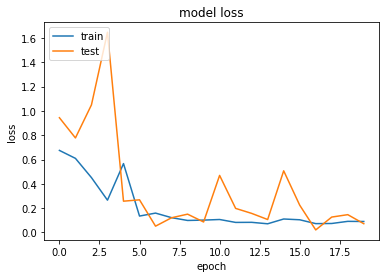

In [8]:
def plot_learning_curve(history):
    plt.plot(history.history['acc'])
    plt.plot(history.history['val_acc'])
    plt.title('model accuracy')
    plt.ylabel('accuracy')
    plt.xlabel('epoch')
    plt.legend(['train', 'test'], loc='upper left')
    plt.savefig('./accuracy_curve.png')
    plt.clf()
    # summarize history for loss
    plt.plot(history.history['loss'])
    plt.plot(history.history['val_loss'])
    plt.title('model loss')
    plt.ylabel('loss')
    plt.xlabel('epoch')
    plt.legend(['train', 'test'], loc='upper left')
    plt.savefig('./loss_curve.png')

plot_learning_curve(history)

# Accuracy

In [9]:
from sklearn.metrics import accuracy_score

print('Predicting on test data')
y_pred = np.rint(model.predict(X_test))

print(accuracy_score(y_test, y_pred))

Predicting on test data
0.962605548854041


# Confusion Matrix

In [10]:
from sklearn.metrics import confusion_matrix

print(confusion_matrix(y_test, y_pred))

[[1162   78]
 [  15 1232]]


# Images Misclassified

In [11]:
false_positive_mononuclear = np.intersect1d(np.where(y_pred == 1), np.where(y_test == 0))
print false_positive_mononuclear

[1430 1451 1601 1668 1806 1810 1869 1874 1879 1895 1923 1935 1966 1974
 1980 1995 1998 2001 2005 2007 2009 2025 2041 2043 2059 2061 2069 2072
 2078 2079 2080 2109 2126 2142 2149 2160 2164 2175 2180 2194 2210 2215
 2219 2223 2231 2232 2246 2251 2252 2276 2289 2291 2312 2314 2317 2325
 2327 2334 2342 2343 2349 2360 2363 2368 2369 2387 2390 2401 2415 2429
 2431 2434 2437 2450 2457 2461 2464 2478]


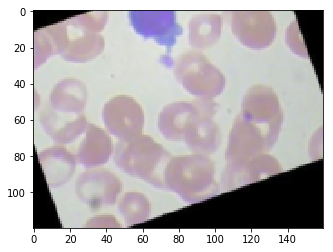

In [12]:
img = X_test[false_positive_mononuclear[0]]
plt.imshow(cv2.cvtColor(img, cv2.COLOR_BGR2RGB))

# Mononuclear Cells Classified Correctly

In [13]:
true_positive_mononuclear = np.intersect1d(np.where(y_pred == 1), np.where(y_test == 1))

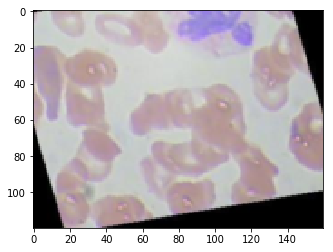

In [14]:
img = X_test[true_positive_mononuclear[0]]
plt.imshow(cv2.cvtColor(img, cv2.COLOR_BGR2RGB))

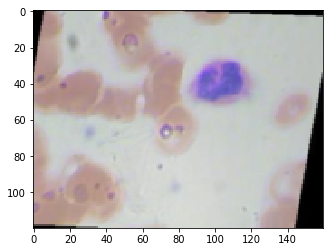

In [15]:
img = X_test[true_positive_mononuclear[5]]
plt.imshow(cv2.cvtColor(img, cv2.COLOR_BGR2RGB))

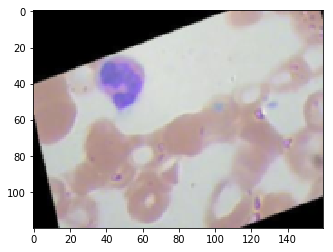

In [16]:
img = X_test[true_positive_mononuclear[8]]
plt.imshow(cv2.cvtColor(img, cv2.COLOR_BGR2RGB))

# Polynuclear Cells Classified Correctly

In [17]:
true_positive_polynuclear = np.intersect1d(np.where(y_pred == 0), np.where(y_test == 0))
print true_positive_polynuclear

[1247 1248 1249 ... 2484 2485 2486]


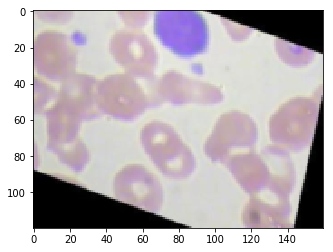

In [18]:
img = X_test[true_positive_polynuclear[21]]
plt.imshow(cv2.cvtColor(img, cv2.COLOR_BGR2RGB))

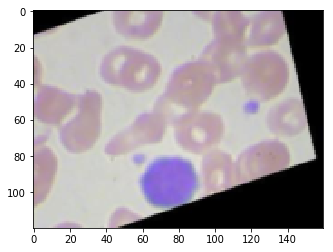

In [19]:
img = X_test[true_positive_polynuclear[53]]
plt.imshow(cv2.cvtColor(img, cv2.COLOR_BGR2RGB))

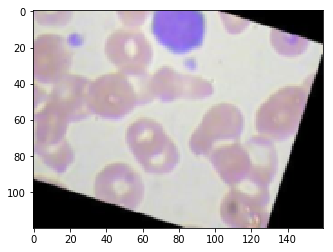

In [20]:
img = X_test[true_positive_polynuclear[16]]
plt.imshow(cv2.cvtColor(img, cv2.COLOR_BGR2RGB))